In [1]:
%matplotlib inline

In [2]:
from __future__ import division


In [3]:

from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as tt
import pandas as pd




C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
blue, *_ = sns.color_palette()

In [5]:
SEED = 5132290 # from random.org

np.random.seed(SEED)

In [6]:
N = 20
K = 30

alpha = 2.
P0 = sp.stats.norm

In [7]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

x_plot = np.linspace(-3, 3, 200)

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

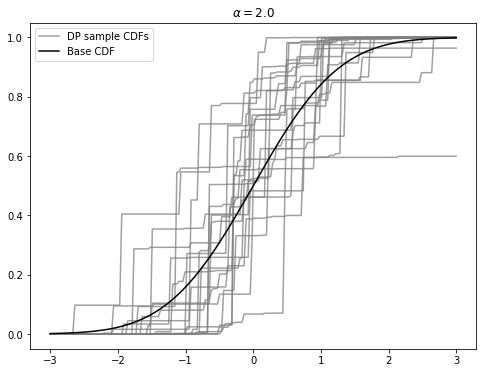

In [8]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
        label='DP sample CDFs');
ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

ax.set_title(r'$\alpha = {}$'.format(alpha));
ax.legend(loc=2);



In [9]:
SEED = 5132290 # from random.org

np.random.seed(SEED)

In [10]:
fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

K = 50
alpha = 10.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

l_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
l_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
l_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

l_ax.set_title(r'$\alpha = {}$'.format(alpha));
l_ax.legend(loc=2);

K = 200
alpha = 50.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

r_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
r_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
r_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

r_ax.set_title(r'$\alpha = {}$'.format(alpha));
r_ax.legend(loc=2);

In [11]:
N = 5
K = 30

alpha = 2
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)

In [12]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = P0.rvs(size=(N, K))

dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)


In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c='gray');

ax.set_yticklabels([]);

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 1

ax.plot(x_plot, dpm_pdfs[ix], c='k', label='Density');
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
        '--', c='k', label='Mixture components (weighted)');
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T,
        '--', c='k');

ax.set_yticklabels([]);
ax.legend(loc=1);

In [15]:
old_faithful_df = pd.read_csv(pm.get_data('old_faithful.csv'))

In [16]:

old_faithful_df['std_waiting'] = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()




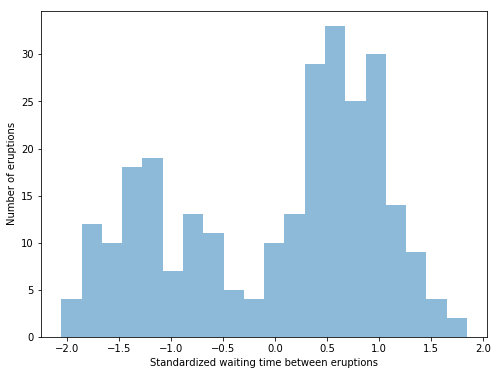

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color=blue, lw=0, alpha=0.5);

ax.set_xlabel('Standardized waiting time between eruptions');
ax.set_ylabel('Number of eruptions');

In [18]:
N = old_faithful_df.shape[0]

K = 30

In [19]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [20]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=old_faithful_df.std_waiting.values)

In [21]:

with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:24<00:00, 24.18draws/s] 
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
with model:
    trace = pm.sample(4000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 18000/18000 [04:13<00:00, 37.88draws/s] 
There were 483 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8329244347896496, but should be close to 0.9. Try to increase the number of tuning steps.
There were 384 divergences after tuning. Increase `target_accept` or reparameterize.
There were 420 divergences after tuning. Increase `target_accept` or reparameterize.
There were 537 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [24]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [03:03<00:00, 54.35draws/s]
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8075316069356223, but should be close to 0.9. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 16000/16000 [03:15<00:00, 24.47draws/s] 
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [26]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.99}, tune = 2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 14000/14000 [10:37<00:00, 11.94draws/s]
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [27]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 1750)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 11000/11000 [03:12<00:00, 57.14draws/s]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8212263988298125, but should be close to 0.9. Try to increase the number of tuning steps.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [28]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [03:19<00:00, 60.04draws/s]
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7774155346720043, but should be close to 0.9. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [29]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.85}, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:54<00:00, 68.75draws/s] 
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [30]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.95}, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [03:14<00:00, 22.81draws/s]
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8938751388316915, but should be close to 0.95. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [31]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.92}, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [03:22<00:00, 22.86draws/s]
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [32]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.95}, tune = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 16000/16000 [04:53<00:00, 54.57draws/s]
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8892102885986533, but should be close to 0.95. Try to increase the number of tuning steps.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [33]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.93}, tune = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 16000/16000 [04:58<00:00, 53.64draws/s] 
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.95}, tune = 1750)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 11000/11000 [04:37<00:00, 39.60draws/s]
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8634966109789621, but should be close to 0.95. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7933545346587991, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of eff

In [35]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 1750)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 11000/11000 [03:07<00:00, 58.58draws/s]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8212263988298125, but should be close to 0.9. Try to increase the number of tuning steps.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 1350)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 9400/9400 [02:46<00:00, 56.54draws/s] 
There were 290 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5491988885528035, but should be close to 0.9. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9797517580768671, but should be close to 0.9. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8050063860848087, but should be close to 0.9. Try to increase the

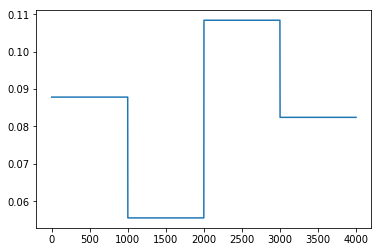

In [22]:
plt.plot(trace['step_size_bar'])

In [23]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:45<00:00, 72.54draws/s]
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7774155346720043, but should be close to 0.9. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [24]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.95}, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [03:11<00:00, 23.97draws/s]
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8938751388316915, but should be close to 0.95. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


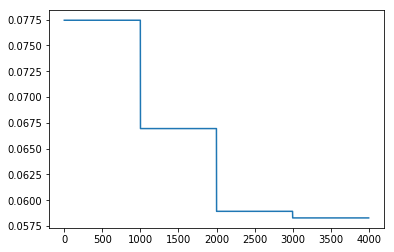

In [25]:
plt.plot(trace['step_size_bar'])

In [26]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.95}, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [02:40<00:00, 16.86draws/s]
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


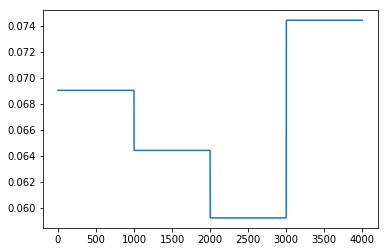

In [27]:
plt.plot(trace['step_size_bar'])

In [22]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.99}, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [19:04<00:00,  1.01draws/s]
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


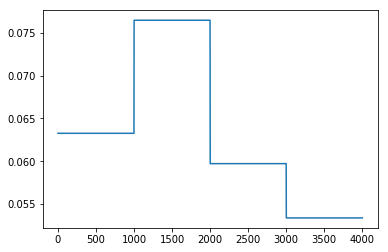

In [22]:
plt.plot(trace['step_size_bar'])

In [23]:
import arviz as az

az.style.use('arviz-darkgrid')

data = az.load_arviz_data('centered_eight')

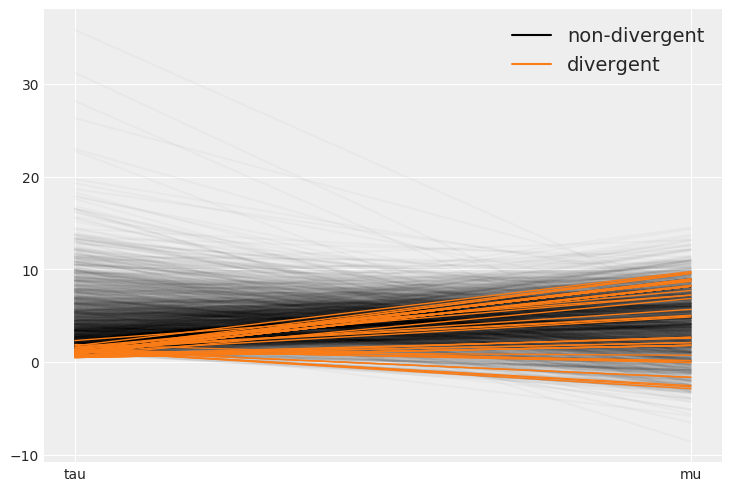

In [24]:
ax = az.plot_parallel(data, var_names=['tau', 'mu', 'lambda', 'alpha', 'beta'])

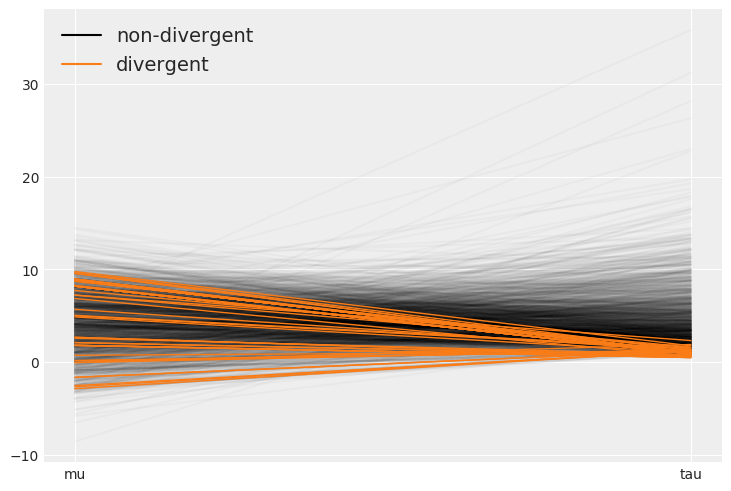

In [28]:
ax = az.plot_parallel(data, var_names=['mu', 'tau'])

In [21]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.99}, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [17:09<00:00,  1.24draws/s]
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [22]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [02:41<00:00, 49.55draws/s]
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7144418492097572, but should be close to 0.9. Try to increase the number of tuning steps.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


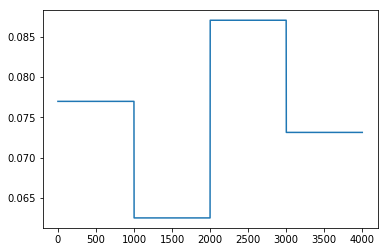

In [23]:
plt.plot(trace['step_size_bar'])

In [25]:
import arviz as az

az.style.use('arviz-darkgrid')

data = az.load_arviz_data('centered_eight')

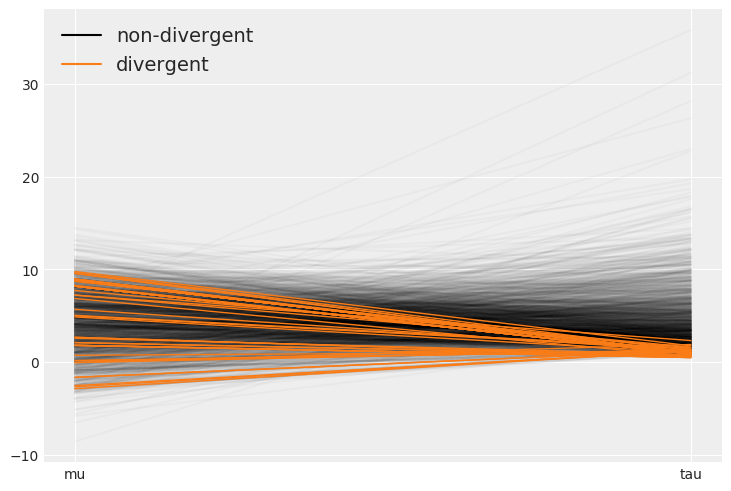

In [26]:
ax = az.plot_parallel(data, var_names=['mu', 'tau'])

In [30]:
with model:
    trace = pm.sample(1000, random_seed=SEED, nuts_kwargs = {'target_accept': 0.9}, tune = 10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains: 100%|██████████| 44000/44000 [08:29<00:00, 86.42draws/s] 
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.817012265854528, but should be close to 0.9. Try to increase the number of tuning steps.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.681822479655001, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effect

In [31]:
import arviz as az

az.style.use('arviz-darkgrid')

data = az.load_arviz_data('centered_eight')

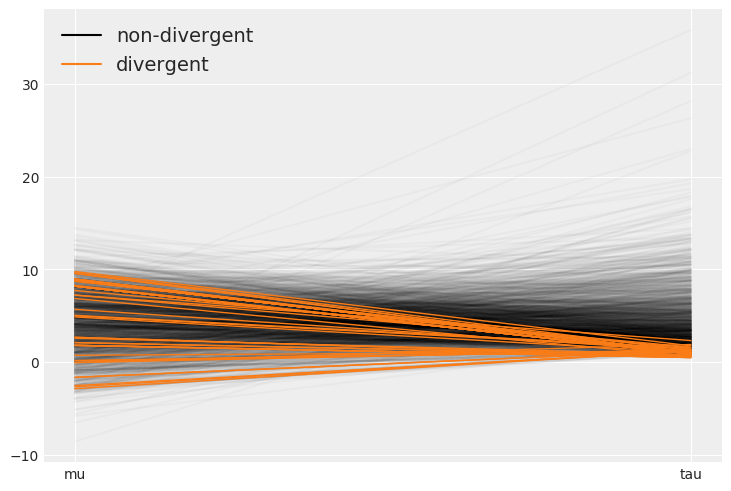

In [32]:
ax = az.plot_parallel(data, var_names=['mu', 'tau'])

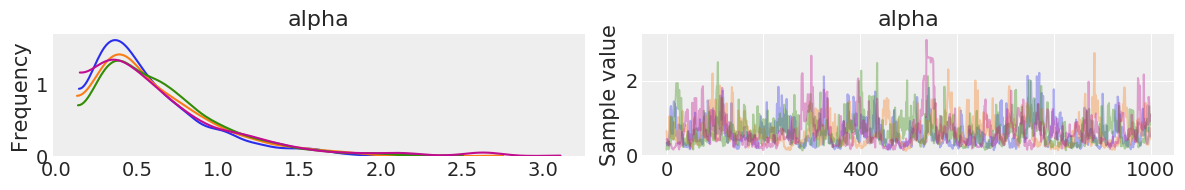

In [34]:


pm.traceplot(trace, varnames=['alpha']);



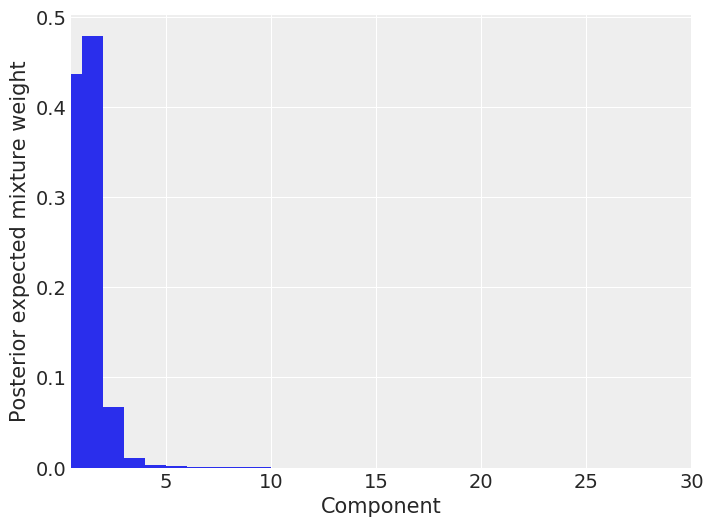

In [35]:


fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');



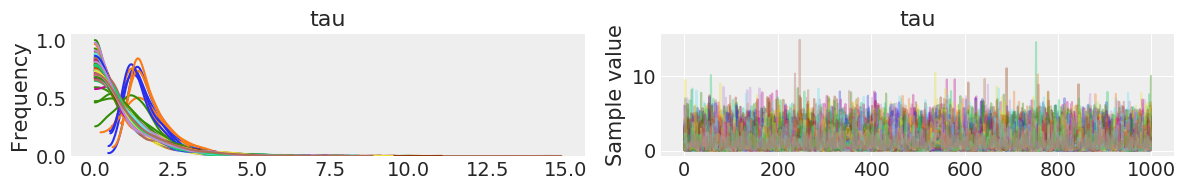

In [36]:

pm.traceplot(trace, varnames=['tau']);

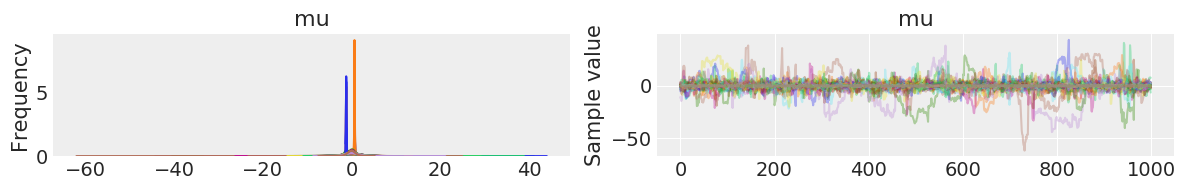

In [37]:
pm.traceplot(trace, varnames=['mu']);

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6ddc39d860>, GridSpec(59, 59))

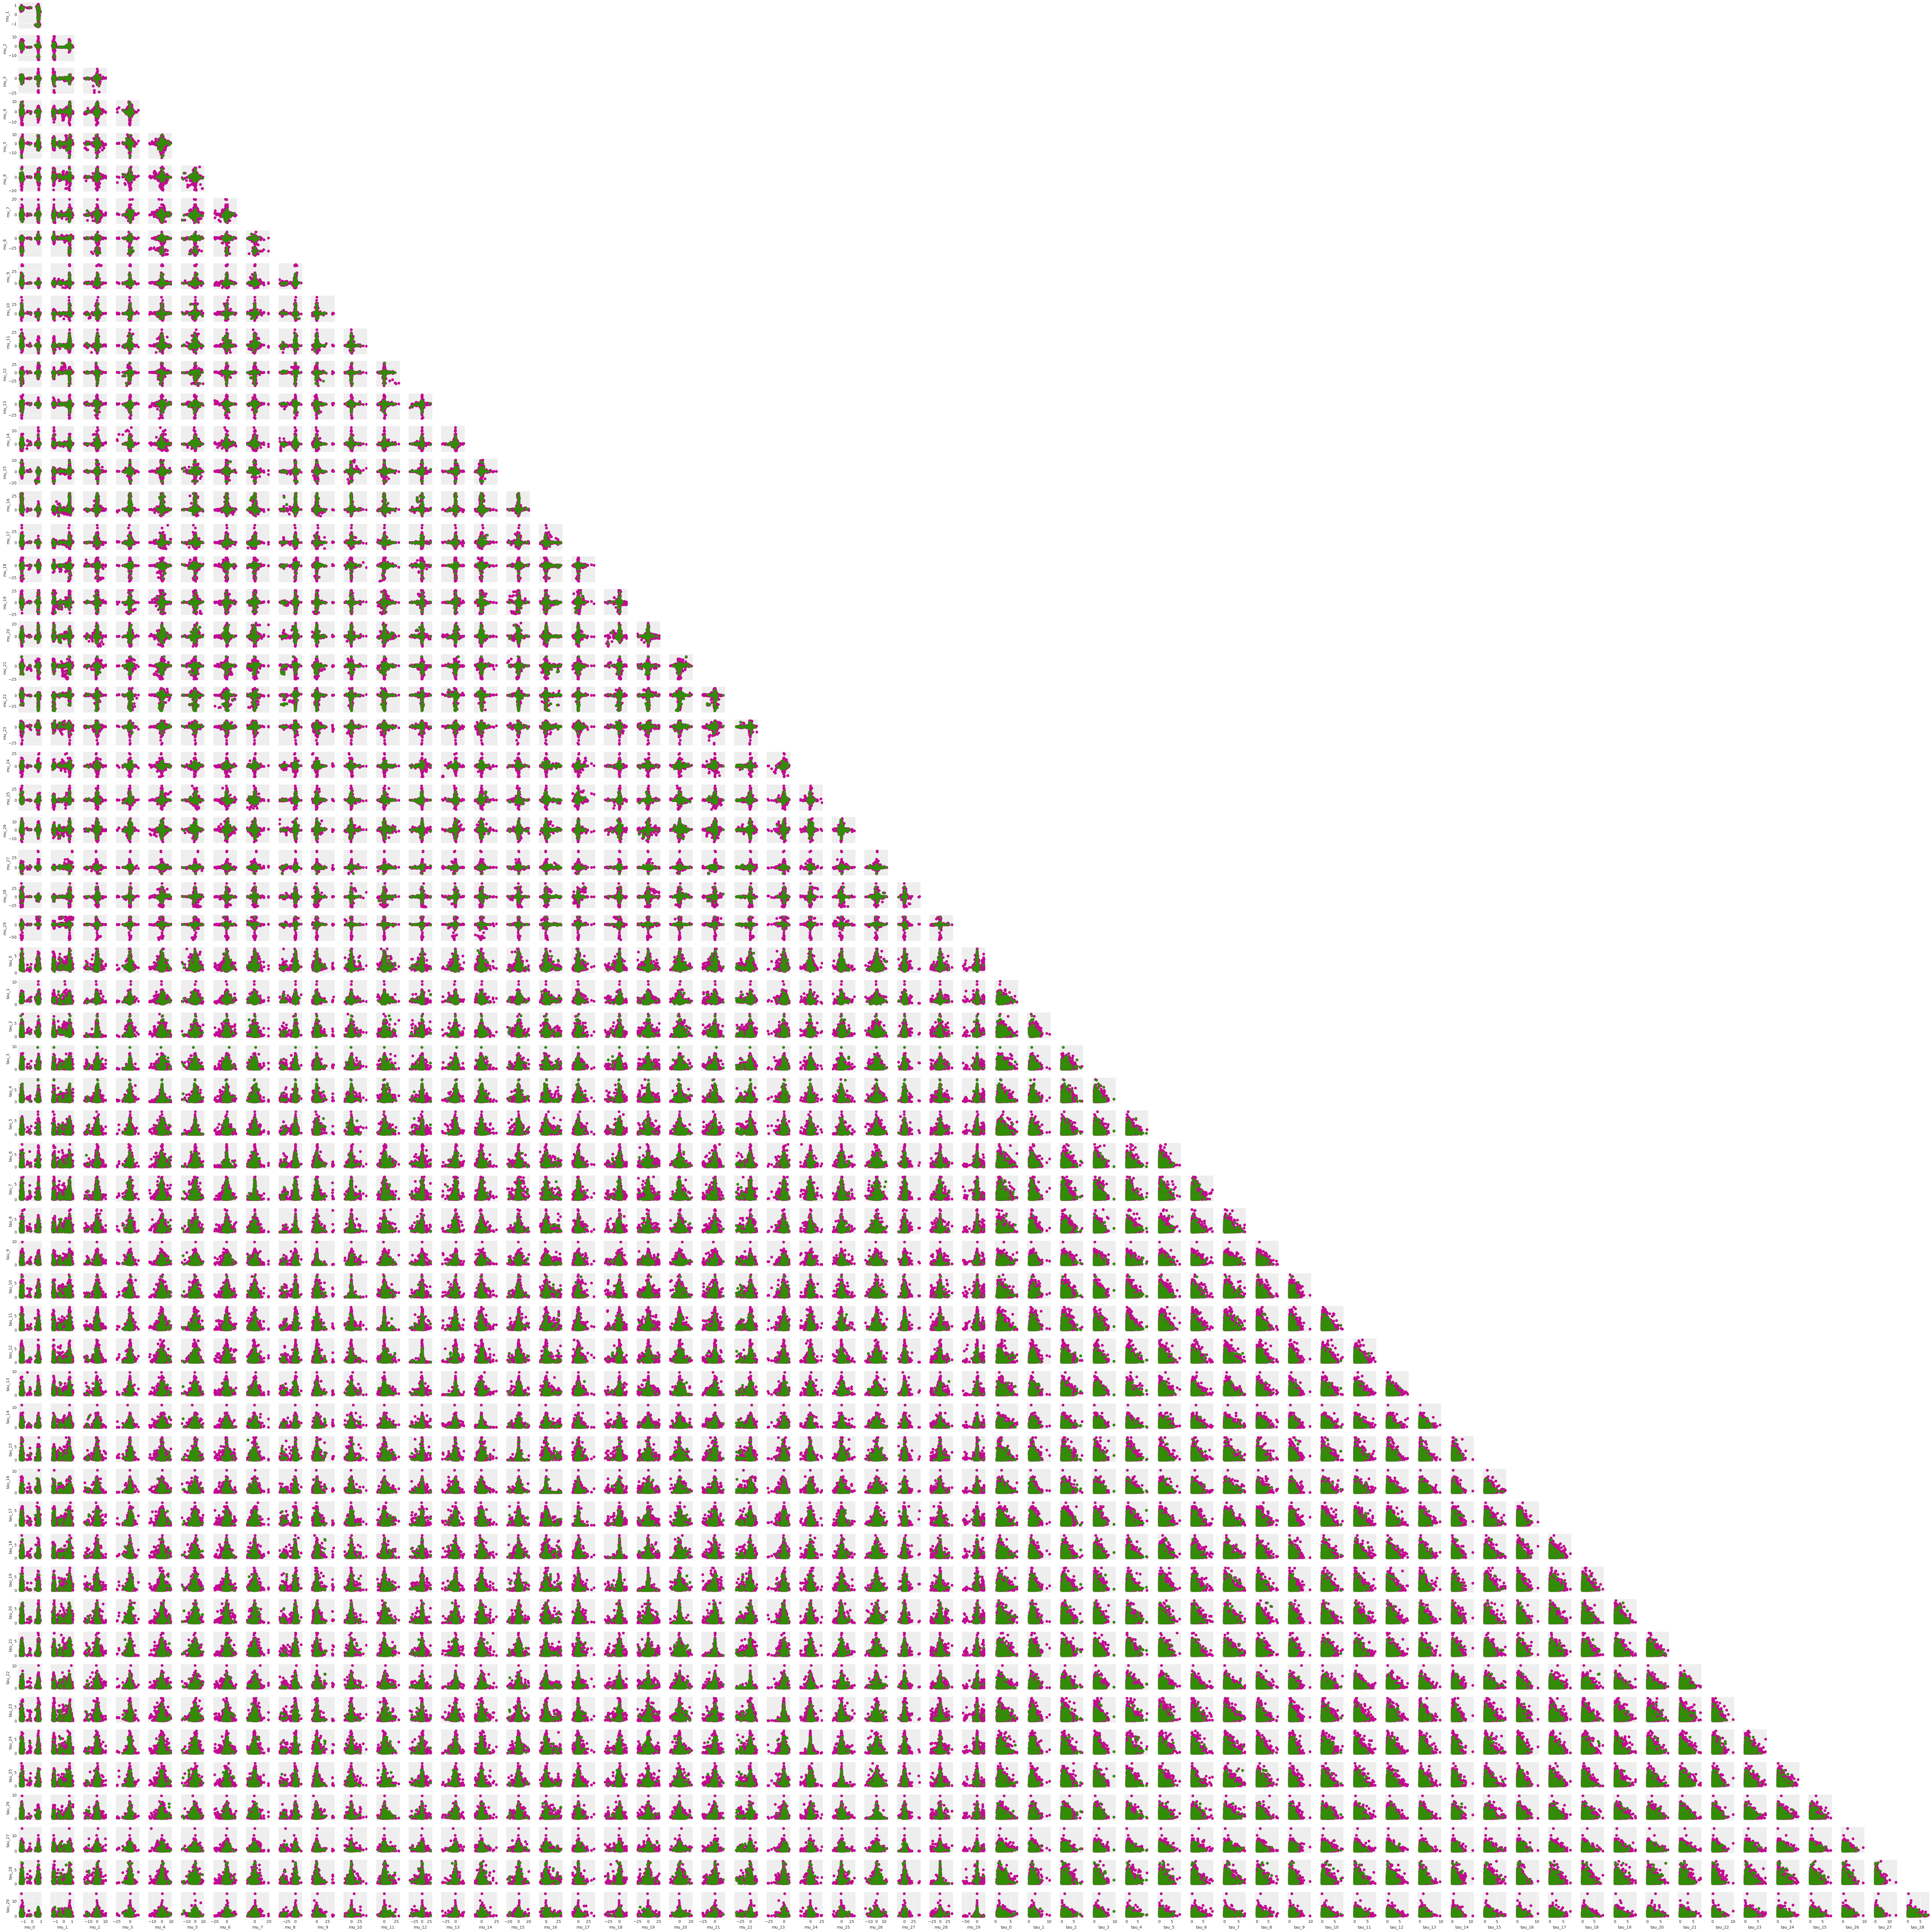

In [38]:
pm.pairplot(trace,
           varnames=['mu', 'tau'],
            divergences=True,
            color='C3',
            kwargs_divergence={'color': 'C2'})



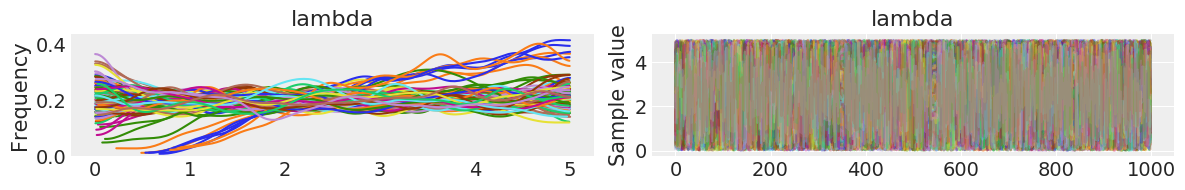

In [39]:

pm.traceplot(trace, varnames=['lambda']);

